# Pembangunan Model Pre-trained YOLO untuk Deteksi Bangunan Wilayah Paris dan Khartoum pada Citra Satelit 



# Melakukan Clone Arsitektur Darknet

Darknet diklon dari repositori github terkenal milik [AlexAB](https://github.com/AlexeyAB/darknet). Kemudian mengatur Makefile untuk mengaktifkan GPU dan OPENCV untuk selanjutnya membangun Darknet.


In [ ]:
# clone darknet repo
%cd .
!git clone https://github.com/AlexeyAB/darknet

/content
Cloning into 'darknet'...
remote: Enumerating objects: 15457, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 15457 (delta 4), reused 21 (delta 2), pack-reused 15424
Receiving objects: 100% (15457/15457), 14.12 MiB | 23.81 MiB/s, done.
Resolving deltas: 100% (10367/10367), done.


In [ ]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

/content/darknet


In [ ]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
# make darknet (build)
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_

# Menyiapkan File dari Google Drive

**Catatan:** Membuat shortcut atau symbolic link antara '/content/drive/MyDrive/ColabNotebooks/ObjectDetection/Paper' dan '/mydrive' agar lebih efisien

In [ ]:
%cd ..
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!ln -s /content/drive/MyDrive/ColabNotebooks/ObjectDetection/Paper /mydrive
%cd ./darknet

# Memindahkan Dataset ke Cloud VM 

Data image dan text label untuk data train dan test yang sudah dikompresi kemudian dipindahkan ke cloud VM. Hal tersebut bertujuan untuk mengurangi waktu yang lama ketika memindahkan dataset yang diupload dari local machine. File kompresi tersebut kemudian diekstraksi pada cloud VM.

In [ ]:
# copy the .zip file into the root directory of cloud VM
!cp /mydrive/Paper/Data/train.zip ../
!cp /mydrive/Paper/Data/test.zip ../

In [ ]:
# unzip the zip file and its contents should now be in /darknet/data/obj
!unzip ../train.zip -d data/
!unzip ../test.zip -d data/

# Konfigurasi File untuk Training


## i) File Cfg 

Pada file ini perlu dilakukan konfigurasi, beberapa hyperparameter perlu ditentukan terlebih dahulu sehingga bisa didapatkan hasil yang lebih maksimal. 
**Input** yang digunakan berukuran 416 x 416 px. Kemudian untuk hasil yang ultimate, kami menggunakan **batch size** = 64 dan **subdivisions** = 32. Model dilatih hingga **maximum batches** = 2000, dengan **steps** = 1600 dan 1800. **Classes** pada 3 layer YOLO diubah menjadi 1 (menandakan hanya kelas bangunan), serta mengubah **filter** = pada 3 convolutional layer sebelum layer YOLO.

Terdapat 2 file Cfg, masing-masing ditujukan untuk baseline dan modified model, yang berbeda pada nilai anchors box.


In [ ]:
# upload the custom .cfg back to cloud VM from Google Drive
!cp /mydrive/config/baseline.cfg ./cfg
!cp /mydrive/config/modified.cfg ./cfg

## ii) Files .names dan .data 

File .names berisi kelas pada dataset yang digunakan untuk training. Pada kasus ini hanya kelas bangunan.


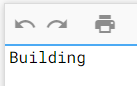

Dan file .data berisi jumlah kelas, serta path untuk file path train dan test, file .names, dan backup. Backup digunakan untuk menyimpan weights dari model selama proses training.

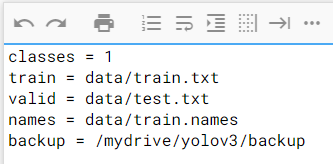

In [ ]:
# upload the train.names and train.data files to cloud VM from Google Drive
!cp /mydrive/config/train.names ./data
!cp /mydrive/config/train.data  ./data

## iii) Generate File train.txt

File konfigurasi terakhir adalah train.txt dan test.txt, di mana file tersebut berisi relative path ke semua data image training.

Script asli dapat diakses dari link ini [Github theAIGuysCode](https://github.com/theAIGuysCode/YoloGenerateTrainingFile/blob/master/generate_train.py/)


In [ ]:
# upload the generate_train.py script to cloud VM from Google Drive
!cp /mydrive/generate_train.py ./
!cp /mydrive/generate_test.py ./

In [ ]:
!python generate_train.py
!python generate_test.py

# Akses Pre-trained Weights untuk Convolutional Layers

Pre-trained weights disini digunakan untuk membantu model mendeteksi dengan lebih akurat dan mmpercepat waktu untuk proses training.


In [ ]:
# upload pretrained convolutional layer weights
!wget http://pjreddie.com/media/files/darknet53.conv.74

--2022-01-08 11:08:09--  http://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pjreddie.com/media/files/darknet53.conv.74 [following]
--2022-01-08 11:08:09--  https://pjreddie.com/media/files/darknet53.conv.74
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  54.7MB/s    in 2.8s    

2022-01-08 11:08:12 (54.7 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



# Training Object Detector YOLOv3

**TIP:** Proses training membutuhkan waktu beberapa jam (model di bawah berkisar 10 jam), tergantung dari seberapa besar iterasi yang digunakan pada file konfigurasi. Sedangkan Colab akan menghentikan running time jika tidak ada aktivitas. Agar kita bisa membiarkan Cloud VM berjalan sendirinya, bisa menggunakan cara di bawah.

Paste kode di bawah ke console, lalu enter.
```javascript
const addCodeBlock = () => {
    document.querySelector("colab-toolbar-button").click()
}
interval = setInterval(addCodeBlock, 1000*60*25) // 25 menit
```

## Baseline Model

Perbedaan baseline model dan modified model adalah dari nilai anchors box nya. Anchors box model ini adalah anchors box default pada COCO dataset.

In [ ]:
!./darknet detector train data/train.data cfg/baseline.cfg darknet53.conv.74 -dont_show -map

Karena belum mencapai maximum batches (iterasi) = 2000 maka dilanjutkan proses training, di mana weightsnya bukan lagi Darknet-53 melainkan weight terakhir yang sudah disimpan pada folder backup

In [ ]:
!./darknet detector train data/train.data cfg/yolov3_custom.cfg /mydrive/yolov3/backup/baseline_last.weights -dont_show -map

## Modified Model

Nilai anchors box model ini didapatkan dari hasil tuning menggunakan K-Means Clustering dengan 9 cluster.

In [ ]:
!./darknet detector train data/train.data cfg/modified.cfg darknet53.conv.74 -dont_show -map

# Evaluasi Model

Hasil evaluasi kedua model menggunakan model best weight diukur dengan 3 nilai IoU threshold yakni 0.25; 0.50; 0.75. Semakin besar IoU threshold, semakin kecil nilai evaluasi yang didapatkan.

## Baseline Model

### IoU Threshold 0.25

Precision = 0.80
Recall = 0.66
AP = 0.7758

TP: 5411, 
FP: 1315, 
FN: 2792

In [ ]:
!./darknet detector map data/train.data cfg/baseline.cfg /mydrive/yolo_weights/model1/baseline_best.weights -iou_thresh 0.25

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,

### IoU Threshold 0.50

Precision = 0.71
Recall = 0.59
AP = 0.6419

TP: 4801, 
FP: 1925, 
FN: 3402

In [ ]:
!./darknet detector map data/train.data cfg/baseline.cfg /mydrive/yolo_weights/model1/baseline_best.weights 

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,

### IoU Threshold 0.75

Precision = 0.39
Recall = 0.32
AP = 0.2298

TP: 2591, 
FP: 4135, 
FN: 5612

In [ ]:
!./darknet detector map data/train.data cfg/baseline.cfg /mydrive/yolo_weights/model1/baseline_best.weights -iou_thresh 0.75

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,

## Modified Model

### IoU Threshold 0.25

Precision = 0.81
Recall = 0.64
AP = 0.7788

TP: 5285, 
FP: 1220, 
FN: 2918

In [ ]:
!./darknet detector map data/train.data cfg/modified.cfg /mydrive/yolov3/backup/modified_best.weights -iou_thresh 0.25

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,

### IoU Threshold 0.50

Precision = 0.72
Recall = 0.57
AP = 0.6387

TP: 4703, 
FP: 1802, 
FN: 3500

In [ ]:
!./darknet detector map data/train.data cfg/modified.cfg /mydrive/yolov3/backup/modified_best.weights 

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,

### IoU Threshold 0.75

Precision = 0.38
Recall = 0.30
AP = 0.2180

TP: 2465, 
FP: 4040, 
FN: 5738

In [ ]:
!./darknet detector map data/train.data cfg/modified.cfg /mydrive/yolov3/backup/modified_best.weights -iou_thresh 0.75

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,

# Menguji Model pada Data Test

Kedua model diujikan pada 2 data test. Fungsi ```imShow``` berfungsi untuk menampilkan hasil deteksi.

In [ ]:
# define helper functions
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5, 

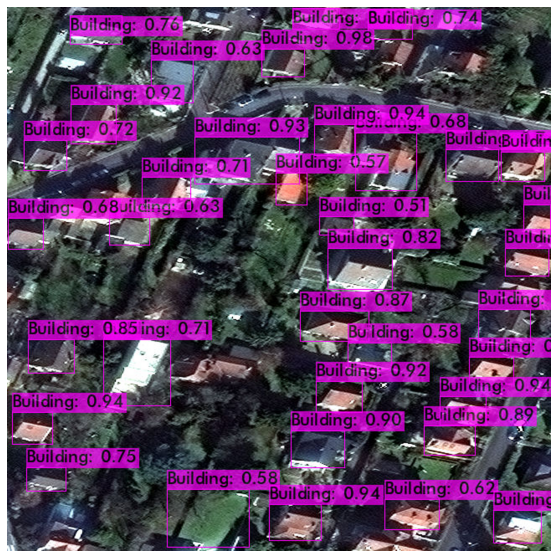

In [ ]:
# run your custom detector with this command (upload an image to your google drive to test, thresh flag sets accuracy that detection must be in order to show it)
!./darknet detector test data/train.data cfg/baseline.cfg /mydrive/yolov3/backup/baseline_best.weights /mydrive/Data/test/RGB-PanSharpen_AOI_3_Paris_img1001.jpg -thresh 0.5
imShow('predictions.jpg')

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,

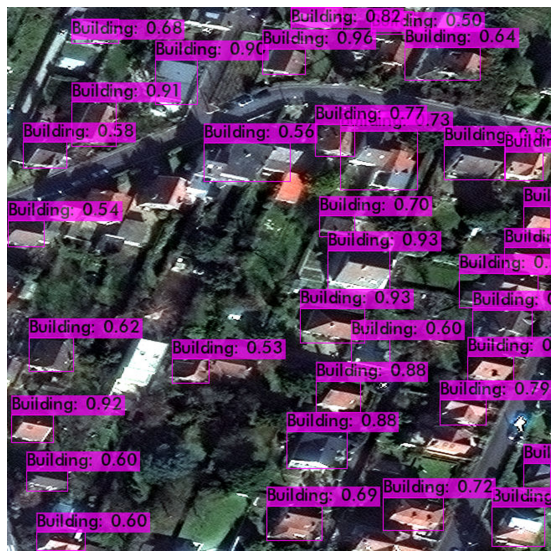

In [ ]:
!./darknet detector test data/train.data cfg/modified.cfg /mydrive/yolov3/backup/modified_best.weights /mydrive/Data/test/RGB-PanSharpen_AOI_3_Paris_img1001.jpg -thresh 0.5
imShow('predictions.jpg')

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5, 

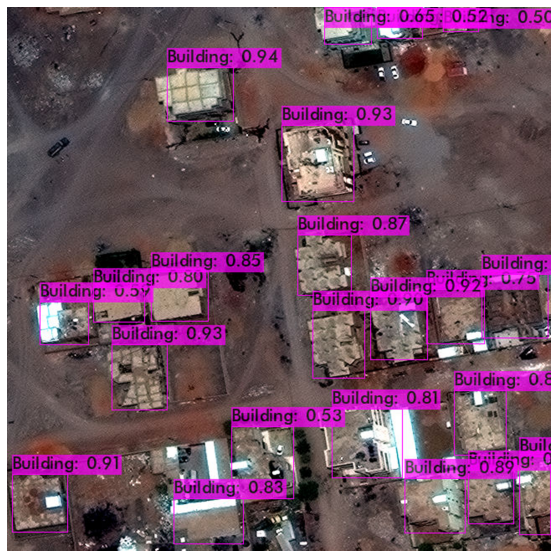

In [ ]:
!./darknet detector test data/train.data cfg/baseline.cfg /mydrive/yolov3/backup/baseline_best.weights /mydrive/Data/test/RGB-PanSharpen_AOI_5_Khartoum_img971.jpg -thresh 0.5
imShow('predictions.jpg')

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,

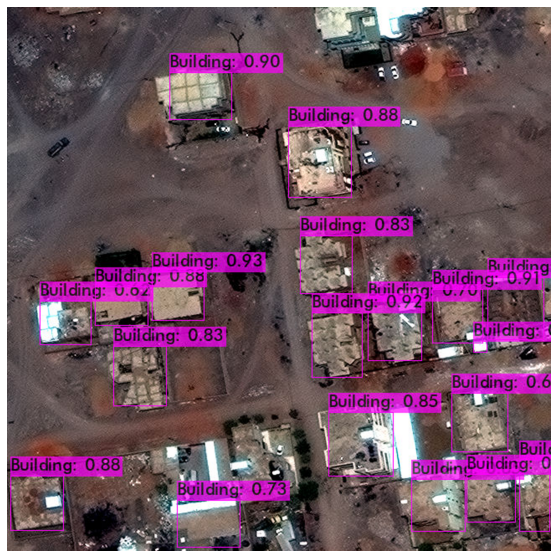

In [ ]:
!./darknet detector test data/train.data cfg/modified.cfg /mydrive/yolov3/backup/modified_best.weights /mydrive/Data/test/RGB-PanSharpen_AOI_5_Khartoum_img971.jpg -thresh 0.5
imShow('predictions.jpg')